<a href="https://colab.research.google.com/github/shivam9887631/placement-management-system/blob/main/Shark_tank_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial dataset shape: (1274, 48)

Missing Values in Each Column:
Season Number                            0
Episode Number                           0
Pitch Number                             0
Original Air Date                        0
Startup Name                             0
Industry                                 0
Business Description                     0
Pitchers Gender                          7
Pitchers City                          772
Pitchers State                         528
Pitchers Average Age                   936
Entrepreneur Names                     495
Company Website                        758
Multiple Entrepreneurs                 427
US Viewership                            0
Original Ask Amount                      0
Original Offered Equity                  0
Valuation Requested                      0
Got Deal                                 0
Total Deal Amount                      509
Total Deal Equity                      509
Deal Valuation                 

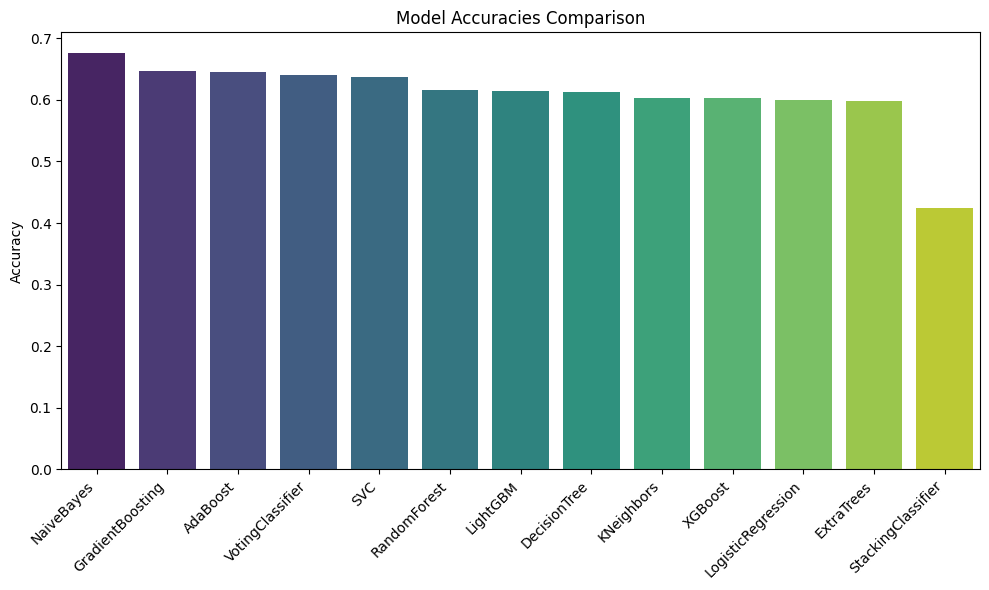


Best Model: NaiveBayes
Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       509
           1       1.00      0.46      0.63       765

    accuracy                           0.68      1274
   macro avg       0.78      0.73      0.67      1274
weighted avg       0.82      0.68      0.66      1274



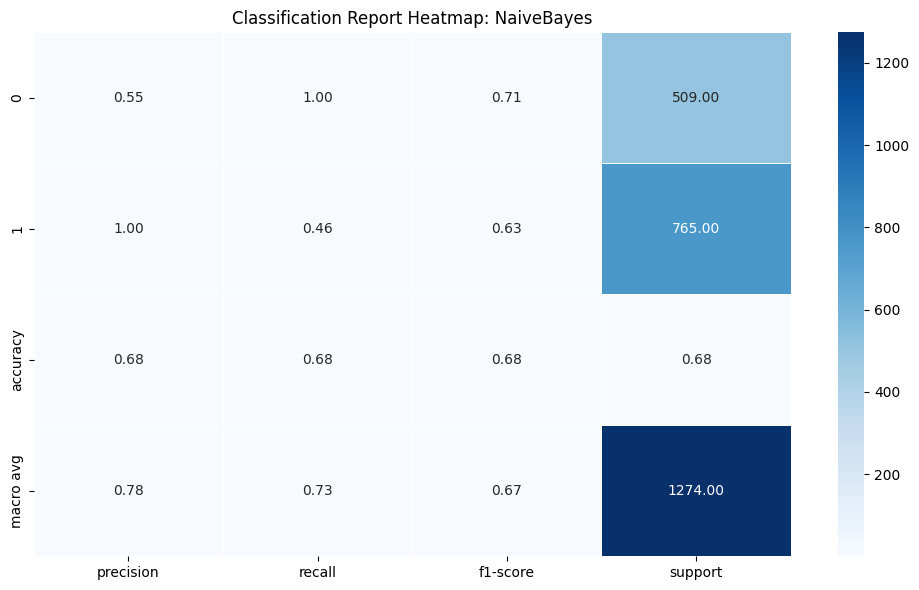

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, \
    ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings

# Ignore warnings for a cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load dataset
data = pd.read_csv('Shark Tank US.csv')

# Print the shape of the initial dataset (number of rows and columns)
print(f"Initial dataset shape: {data.shape}")

# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Define the target variable ('Got Deal') and feature matrix (X)
target_column = "Got Deal"  # Specify the target variable column name
X = data.drop(columns=[target_column])  # All columns except the target variable
y = data[target_column]  # The target variable

# Drop rows where the target variable ('Got Deal') has missing values
data = data.dropna(subset=[target_column])  # Dropping rows with missing target values
X = data.drop(columns=[target_column])  # Redefine feature matrix X
y = data[target_column]  # Redefine target variable y

# Fill missing values in feature columns
# For numerical columns, fill missing values with the median
for col in X.select_dtypes(include=["float", "int"]).columns:
    X[col].fillna(X[col].median(), inplace=True)
# For categorical columns, fill missing values with the mode (most frequent value)
for col in X.select_dtypes(include=["object"]).columns:
    X[col].fillna(X[col].mode()[0], inplace=True)

# Encode categorical variables into numerical values using one-hot encoding
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables
y = LabelEncoder().fit_transform(y)  # Encode the target variable ('Got Deal') into 0 and 1

# Print the shape of the updated dataset after encoding and filling missing values
print(f"\nFeatures shape: {X.shape}, Target shape: {y.shape}")

# Exclude columns that might have data leakage or are irrelevant for the model
excluded_features = [
    "Total Deal Amount", "Total Deal Equity", "Deal Valuation", "Number of sharks in deal",
    "Investment Amount Per Shark", "Equity Per Shark", "Royalty Deal", "Loan"
]
X = X.drop(columns=[col for col in excluded_features if col in X.columns], errors="ignore")

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()  # Initialize the scaler
X_scaled = scaler.fit_transform(X)  # Standardize the feature matrix

# Apply feature selection using SelectKBest with ANOVA F-statistic as the scoring function
selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features based on ANOVA F-statistic
X_reduced = selector.fit_transform(X_scaled, y)  # Reduce the feature matrix to top 10 features

# Define classifiers to be evaluated
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(random_state=42, probability=True),
    "KNeighbors": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=5000, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(verbosity=-1, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
}

# Adding ensemble models: Voting and Stacking classifiers
voting_classifier = VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                                                 ('svc', SVC(random_state=42, probability=True)),
                                                 ('gb', GradientBoostingClassifier(random_state=42))],
                                     voting='soft')  # Voting classifier using soft voting
stacking_classifier = StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                                                     ('svc', SVC(random_state=42, probability=True)),
                                                     ('dt', DecisionTreeClassifier(random_state=42))],
                                         final_estimator=LogisticRegression())  # Stacking classifier with logistic regression as final estimator

# Add the ensemble models to the classifiers dictionary
classifiers["VotingClassifier"] = voting_classifier
classifiers["StackingClassifier"] = stacking_classifier

# Define cross-validation strategy (StratifiedKFold ensures balanced splits)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = {}

# Evaluate each classifier using cross-validation and store the accuracy
for name, model in classifiers.items():
    y_pred = cross_val_predict(model, X_reduced, y, cv=cv)  # Cross-validated predictions
    acc = accuracy_score(y, y_pred)  # Calculate accuracy of the model
    results[name] = acc  # Store accuracy in the results dictionary

# Sort the results by accuracy in descending order
results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
print("\nCross-Validated Accuracy Results:")

# Print the accuracy of each model
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

# Create a DataFrame to display results
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df["Accuracy"] = results_df["Accuracy"].round(4)  # Round accuracies to 4 decimal places

# Styling the results table to make it visually appealing
styled_results_df = results_df.style.background_gradient(cmap="viridis")  # Add color gradient to the table
styled_results_df.set_table_styles([{
    'selector': 'thead th',  # Apply styles to the header row
    'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]
}, {
    'selector': 'tbody td',  # Apply styles to the data rows
    'props': [('background-color', '#f9f9f9')]
}])

# Display the styled table
styled_results_df

# Plot model accuracy results as a bar plot
plt.figure(figsize=(10, 6))  # Set plot size
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")  # Plot bars for each model
plt.title("Model Accuracies Comparison")  # Title of the plot
plt.ylabel("Accuracy")  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate X-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Save the accuracy results to a CSV file
results_df.to_csv("model_accuracies.csv", index=False)

# Identify the best-performing model based on accuracy
best_model_name = max(results, key=results.get)
best_model = classifiers[best_model_name]  # Retrieve the best model based on accuracy

# Final evaluation of the best model
y_pred_final = cross_val_predict(best_model, X_reduced, y, cv=cv)  # Get final predictions for the best model
report = classification_report(y, y_pred_final, output_dict=True)  # Generate the classification report
print(f"\nBest Model: {best_model_name}")
print("Classification Report:")
print(classification_report(y, y_pred_final))  # Print the classification report

# Plot the classification report as a heatmap for better visualization
report_df = pd.DataFrame(report).transpose()  # Convert the report to a DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)  # Heatmap of the classification report
plt.title(f"Classification Report Heatmap: {best_model_name}")  # Title of the heatmap
plt.tight_layout()  # Adjust layout
plt.show()

# Save the classification report to a CSV file
report_df.to_csv(f"{best_model_name}_classification_report.csv", index=True)

# Save the final dataset (X_reduced) to a CSV file
final_data = pd.DataFrame(X_reduced, columns=[f"Feature_{i}" for i in range(1, X_reduced.shape[1] + 1)])  # Create DataFrame for reduced features
final_data['Got Deal'] = y  # Add the target column back to the dataset
final_data.to_csv('final_dataset.csv', index=False)  # Save to CSV

# Feature importance plot (for models that support it, like RandomForest